# Natural Language Processing of Subreddit Posts

## Problem Statement

Coach Ella Advisors requests the creation of a machine learning-based algorithm to identify the ways they can maximize the efficiency of their marketing spend based on their target audience.

## Table of Contents

- [Background](#Background)
- [Data Collection and Cleaning](#DCC) 
- [Exploratory Data Analysis and Modeling](#EDAM)
- [Explanatory Data Analysis](#EDA) 
- [Conclusion and Recommendation](#CR) 


## Client/Background <a class="anchor" id="Background"></a>

Coach Ella Advisors is a newly created boutique financial advisory firm which provides advice to younger clients on personal financial health and planning. Although they have applied for an investment advisory license, it has yet to be approved. The founding team at Coach Ella believes that waiting for the approval of their investment advisory license would take too long and wishes to start marketing themselves immediately. As a newly created firm, they wish for us to minimize wasteful spending as they are unable to accept clients for or provide investment advice. However, they would also like for us to find the most efficient way to identify their potential clients as well.

Financial coach, per [Nerdwallet](https://www.nerdwallet.com/article/investing/financial-coach) is

> An advisor who can help you reach your financial goals by teaching you money management skills, such as how to build savings or pay down debt. A financial coach can help improve your financial literacy, but they likely cannot give you investment advice.

Financial coaches such as [Ramsay Solutions](https://www.ramseysolutions.com/ramseyplus/financial-coaching), [Teh Financial Coach](https://www.tehfinancialcoaching.com) and [Dorethia Kelly](https://dorethiakelly.com/personal-finance-coaching/) provide financial advice for a person's financial health. For instance, financial coaches provide advice for how their clients can pay down their student debt, or afford a mortgage while saving for retirement.

On the other hand, a financial advisor provides investment advice in addition to financial coaching. The main difference is that while a financial coach is legally disallowed to provide investment advice by suggesting clients to 'buy this stock' or 'buy that house', financial advisors who have obtained their [personal qualifications](https://www.investopedia.com/ask/answers/091815/do-financial-advisors-have-be-licensed.asp#:~:text=While%20there%20is%20not%20a,licenses%20to%20sell%20investment%20products.&text=These%20include%20the%20Series%206,63%20and%20Series%2065%20licenses.), and firms who are licensed to provide such services, are allowed to provide investment advice.

In this scenario, while Coach Ella Advisors is a financial advisory firm, they have yet to obtain approval to provide investment advice. As such, they are only legally allowed to provide coaching services.


## Problem Statement Analysis

Our client requests a predictive model that distinguishes between their target audience and non-target audience. Specifically, since Coach Ella is not legally allowed to provide investment advice, we would need to find a way to identify and avoid this non-target group. Due to a small budget, Coach Ella wants us to focus on minimizing the spending on non-target group. However, they would like us to not discount other metrics as well. This translates to placing a higher value on 'specificity' while keeping an eye on our other metrics.

**Target Group:** Potential clients for coaching and advisory services on personal financial health and planning.

**Avoidance/Reject Group:** Clients who require or look for investment advice.

**Metrics:** To maximize the efficiency of Coach Ella's marketing budget, we should optimize a few metrics:

|Metric|Description|
|------|-----------|
|Accuracy|Higher accuracy means maximizing identification of target and non-target audience|
|Sensitivity|Higher sensitivity minimizes missed target audience|
|Specificity|Higher specificity minimizes wasteful spending on non-target audience|
|Precision|Higher precision maximizes efficient spending on target audience|

**Note: We highlighted our metric of concern <font color='blue'>blue</font>.**

<br></br>
**Datasets Used:** 

Reddit data obtained through [PushShift API](https://github.com/pushshift/api). The following are the subreddits selected to find target and avoidance group:

|Subreddit|Remarks|
|---------|-------|
|[r/personalfinance](https://www.reddit.com/r/personalfinance/)|Target Group|
|[r/investing](https://www.reddit.com/r/investing/)|Avoidance Group|


## Overall Methodology

We outline the steps that we will take to complete this project:

    1. Collect Subreddit Data
        a. Clean Subreddit Data:
        b. Conduct Necessary Permutations
    2. Exploratory Data Analysis
        a. Data Visualization
        b. Model Creation
        c. Model Evaluation
    3. Explanatory Data Analysis
        a. Feature Importance
        b. Misclassification Analysis
    4. Conclusion and Recommendation

# Imports

In [47]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [1]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup 

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import re

# Data Collection & Cleaning <a class="anchor" id="DCC"></a>

## Data Collection

In this section, we collect data from Reddit using [Pushift API for Reddit](https://github.com/pushshift/api). The two subreddits we have chosen are: **r/investing** and **r/personalfinance**. In collecting this data, we have several objectives and observations:

### Objective
1. Collect at least 1100 non-duplicate texts from each subreddit.
2. Collect 'title', 'subreddit', 'selftext' and 'created_utc'.

### Observations
1. We note that at some requests, an Error 502 will occur. To resolve this, we create a loop to request continuously until the error is solved.
2. Since only 100 submissions can be obtained at one time, we need to create a loop to get earlier data (101st data onwards).

### Methodology
1. Create a continous loop whereby data collection ends only after 1000 non-duplicate texts are obtained.
2. Create a loop to resolve 502 Error by re-requesting.
3. Create a time setting where 'before' parameter will be set to the earliest submission found. As such, the next loop will collect data from earlier submissions, in this case, the 101st datapoint and beyond.
4. When no submissions are found in 100 loops, our code will infinitely loop. As such, we print a warning and stop the loop.
5. Create a loop counter to check the progress of the data collection and ensure that the code is running properly.
6. Create a dataframe for aggregation of data

**Important note: We have repeated this function numerous times to check it for issues. The function works. However, sometimes, an error will appear which may be due to many factors including API usage limit and internet connection stability. This breaks the process. In such cases, please reload the cell.**

In [2]:
personal_df = pd.DataFrame()
insufficient_data = True
epoch = 1632489845     # SG Time: Friday, September 24, 2021 9:24:05 PM
loop_count = 0

while insufficient_data:
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': 'personalfinance',
        'size': 100,
        'before': epoch,}

    # This is used later on to check if the program is continously looping onto itself.
    old_epoch = epoch
    res = requests.get(url, params)
    
    # Sometimes, Error 502 occurs. To resolve, we request again (akin to refreshing page)
    while res.status_code != 200:
        time.sleep(0.5)
        res = requests.get(url, params)
        
    data = res.json()
    posts = data['data']
    full_data = pd.DataFrame(posts)
    
    # Selecting the columns we want
    selected_cols = full_data[['subreddit', 'title', 'selftext', 'created_utc']]
    
    # Dropping unusable selftext
    selected_cols = selected_cols.dropna(subset=['selftext'])
    selected_cols_clean = selected_cols.loc[(selected_cols['selftext'] != '[removed]')
                                            & (selected_cols['selftext'] != '[deleted]')
                                            & (selected_cols['selftext'] != '')]
    
    # Adding data to main dataframe
    personal_df = pd.concat(objs=[personal_df, selected_cols_clean], axis=0)
    
    # Dropping duplicates within the same subreddit
    personal_df.drop_duplicates(subset=['selftext'], inplace=True)
    
    # Checking length of main dataframe
    len(personal_df)
        
    # For checking only
    loop_count += 1
    print(loop_count, len(personal_df))
    
    # Setting new epoch for next loop as the earliest time created out of the 100 posts obtained
    epoch = personal_df['created_utc'].iloc[-1]
    
    # Error tracking: If this is true, it will result in infinite loop
    if old_epoch == epoch:
        print('SAME OLDEST POST. ONE INFINITE LOOP')
        insufficient_data = False
    
    if len(personal_df) >= 1100:
        insufficient_data = False
        
personal_df.to_csv('personalfinance.csv')

1 79
2 163
3 251
4 328
5 400
6 476
7 560
8 634
9 719
10 807
11 896
12 980
13 1060
14 1138


In [3]:
investing_df = pd.DataFrame()
insufficient_data = True
epoch = 1632489845     # SG Time: Friday, September 24, 2021 9:24:05 PM
loop_count = 0

while insufficient_data:
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': 'investing',
        'size': 100,
        'before': epoch,}
    
    # This is used later on to check if the program is continously looping onto itself.
    old_epoch = epoch
    res = requests.get(url, params)
    
    # Sometimes, Error 502 occurs. To resolve, we request again (akin to refreshing page)
    while res.status_code != 200:
        time.sleep(0.5)
        res = requests.get(url, params)
        
    data = res.json()
    posts = data['data']
    full_data = pd.DataFrame(posts)
    
    # Selecting the columns we want
    selected_cols = full_data[['subreddit', 'title', 'selftext', 'created_utc']]
    
    # Dropping unusable selftext
    selected_cols = selected_cols.dropna(subset=['selftext'])
    selected_cols_clean = selected_cols.loc[(selected_cols['selftext'] != '[removed]')
                                            & (selected_cols['selftext'] != '[deleted]')
                                            & (selected_cols['selftext'] != '')]
    
    # Adding data to main dataframe
    investing_df = pd.concat(objs=[investing_df, selected_cols_clean], axis=0)
    
    # Dropping duplicates within the same subreddit
    investing_df.drop_duplicates(subset=['selftext'], inplace=True)
    
    # Checking length of main dataframe
    len(investing_df)
        
    # For checking only
    loop_count += 1
    print(loop_count, len(investing_df))
    
    # Setting new epoch for next loop as the earliest time created out of the 100 posts obtained
    epoch = investing_df['created_utc'].iloc[-1]
    
    # Error tracking: If this is true, it will result in infinite loop
    if old_epoch == epoch:
        print('SAME OLDEST POST. ONE INFINITE LOOP')
        insufficient_data = False
    
    if len(investing_df) >= 1100:
        insufficient_data = False
        
investing_df.to_csv('investing.csv')

1 16
2 28
3 48
4 62
5 77
6 87
7 104
8 119
9 142
10 154
11 175
12 186
13 197
14 211
15 221
16 237
17 262
18 272
19 287
20 293
21 311
22 322
23 341
24 357
25 373
26 400
27 407
28 421
29 434
30 450
31 465
32 481
33 499
34 518
35 531
36 547
37 564
38 581
39 597
40 615
41 639
42 662
43 678
44 696
45 711
46 727
47 742
48 756
49 776
50 790
51 810
52 821
53 842
54 862
55 884
56 902
57 919
58 935
59 945
60 961
61 976
62 999
63 1019
64 1035
65 1053
66 1070
67 1093
68 1113


## Merging Datasets


### Merge Data from Two Subreddits
We merge the two datasets, after which we drop columns if duplicates are found between the two subreddits. Since we are merging two datasets which originally has its own indexes, we reset the index and replace the original indexes to one new index. We note that since two dataframes have the same columns, using Pandas concatenate will suffice. The number of data obtained from each subreddit:

|Subreddit|Count of data collected|
|---------|-----------------------|
|r/PersonalFinance|1138|
|r/Investing|1113|


In [4]:
combined_df = pd.concat(objs=[investing_df, personal_df], axis=0)
combined_df.drop_duplicates(subset=['selftext'], inplace=True)
combined_df.reset_index(inplace=True, drop=True)
combined_df['subreddit'].value_counts()

personalfinance    1138
investing          1113
Name: subreddit, dtype: int64

### Drop Unnecessary Column, Dummify Target Column

In our earlier data collection, we had collected 'created_utc' as a way to monitor the data collection process. Here, we drop the column for it is no longer useful going forward. We also create a dummy for the target column 'subreddit' as such:

|<center>Original:<br>subreddit</br></center>|<center>Dummy:<br>subreddit_personalfinance</center>|
|-----|--|
|<center>personalfinance</center>|<center>1</center>|
|<center>investing</center>|<center>0</center>|


In [5]:
combined_df.drop(columns=['created_utc'], inplace=True)
combined_df['subreddit_personalfinance'] = combined_df['subreddit'].map(lambda x: 1 if x == 'personalfinance' else 0)

## Data Cleaning

We clean the data in several parts:

### Regex

We use regex to drop certain texts that we will not be using from our 'title' and 'subreddit' columns:

    1. URLs (http and https)
    2. Special html terms
    3. Numbers (all digits)
    4. All special characters

|Special Term Removed|Description|
|--------------------|-----------|
|<center>\&amp;#x200B;</center>|Zero-Width Space|
|<center>\&lt;</center>| Smaller than sign (<)|
|<center>\&gt;</center>| Greater than sign (>)|
|<center>\&amp;</center>|Ampersand (&)|

In [6]:
def regex_clean(row):
        
    # Remove links
    row['selftext'] = re.sub(
        pattern=r'\w+:\/\/[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', 
        repl='', 
        string=row['selftext'],
        flags=re.M)
    row['title'] = re.sub(
        pattern=r'\w+:\/\/[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', 
        repl='', 
        string=row['title'],
        flags=re.M)
    
    # Remove special terms    
    row['selftext'] = re.sub(
        pattern='#x200B;|&lt;|&gt;|&amp;|_',
        repl='',
        string=row['selftext'])
    row['title'] = re.sub(
        pattern='#x200B;|&lt;|&gt;|&amp;|_',
        repl='',
        string=row['title'])
    
    # Remove all digits
    row['selftext'] = re.sub(
        pattern=r'\d+',
        repl='',
        string=row['selftext'])
    row['title'] = re.sub(
        pattern=r'\d+',
        repl='',
        string=row['title'])
    
    # Remove all special characters
    row['selftext'] = re.sub(
        pattern=r'\W+',
        repl=' ',
        string=row['selftext'])
    row['title'] = re.sub(
        pattern=r'\W+',
        repl=' ',
        string=row['title'])

    return row
    
clean_df = combined_df.apply(regex_clean, axis=1)

### Create List of Stop Words

First, we create a list of stop words to drop as part of our data cleaning. 
We believe that while the stop words available in the corpus is useful to use for data cleaning, it does not sufficiently drop words that we want to eliminate. 
Therefore, we will use NLTK Corpus Stopwords as a base and add several words according to our requirements.
We have added our subreddit names and several of its permutations to decrease the potential of overfitting due to their relatively higher usage in their respective subreddits. Below, we show our list of stopwords.

|Word(s) Removed|Reason for Removal|
|---------------|------------------|
|invest, investor|Stem and permutations of our subreddit name 'investing'|
|finance, financi, <br>personal, person|Stem and permutation of our subreddit name 'personalfinance'|
|advancethank|Filler word to fulfill subreddit word requirement<br>Hence, it is a stopword with no significant predictive value</br>|
|filer, filler|Filler word to fulfill subreddit word requirement.<br>Hence, it is a stopword with no significant predictive value</br>|
|text|Filler word to fulfill subreddit word requirement.<br>Hence, it is a stopword with no significant predictive value</br>|

In [7]:
additional_stopwords = ['invest', 'investor', 'finance', 'financi', 
                        'personal', 'person', 'advancethank', 'filer', 
                        'filler', 'text']
all_stopwords = stopwords.words('english')
all_stopwords.extend(additional_stopwords)

### Tokenize, Lemma/Stem, Drop Stop Words

Next, we tokenize using RegexpTokenizer and stem using 3 methods:

    1. WordNetLemmatizer
    2. PorterStemmer
    3. SnowballStemmer

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()
snow_stem = SnowballStemmer(language='english')

def tok_stem_drop(row):

    # Tokenize. This creates a list
    row['selftext'] = [tok for tok in tokenizer.tokenize(row['selftext'].lower())]
    row['title'] = [tok for tok in tokenizer.tokenize(row['title'].lower())]
    
    # Lemmatizing, Porter Stemming and Snowball Stemming
    row['lemma_selftext'] = [lemmatizer.lemmatize(tok) for tok in row['selftext']]
    row['porter_selftext'] = [p_stemmer.stem(tok) for tok in row['selftext']]
    row['snow_selftext'] = [snow_stem.stem(tok) for tok in row['selftext']]
    
    row['lemma_title'] = [lemmatizer.lemmatize(tok) for tok in row['title']]
    row['porter_title'] = [p_stemmer.stem(tok) for tok in row['title']]
    row['snow_title'] = [snow_stem.stem(tok) for tok in row['title']]    
        
    # Drop stop words made in Part 1.3.2.
    row['lemma_stop_selftext'] = [tok for tok in row['lemma_selftext'] if tok not in all_stopwords]
    row['porter_stop_selftext'] = [tok for tok in row['porter_selftext'] if tok not in all_stopwords]
    row['snow_stop_selftext'] = [tok for tok in row['snow_selftext'] if tok not in all_stopwords]

    row['lemma_stop_title'] = [tok for tok in row['lemma_title'] if tok not in all_stopwords]
    row['porter_stop_title'] = [tok for tok in row['porter_title'] if tok not in all_stopwords]
    row['snow_stop_title'] = [tok for tok in row['snow_title'] if tok not in all_stopwords]
    
    # Extending 'title' list with corresponding 'selftext' list
    row['lemma_stop_title'].extend(row['lemma_stop_selftext'])
    row['porter_stop_title'].extend(row['porter_stop_selftext'])
    row['snow_stop_title'].extend(row['snow_stop_selftext'])
    row['title'].extend(row['selftext'])

    # Join title and selftext into string
    row['tok_lemma_all_text'] = ' '.join(row['lemma_stop_title'])   
    row['tok_porter_all_text'] = ' '.join(row['porter_stop_title'])
    row['tok_snow_all_text'] = ' '.join(row['snow_stop_title'])
    row['all_text'] = ' '.join(row['title'])
    
    return row
    
clean_df = clean_df.apply(tok_stem_drop, axis=1)

### Drop Unused Columns

We end the data cleaning portion by reducing our number of columns, keeping only those that are necessary for the modeling segment. This helps keep our data concise and allows faster loading time going forward.

In [9]:
clean_df.drop(columns=['title', 'lemma_title', 'porter_title', 'snow_title', 
                       'lemma_stop_selftext', 'porter_stop_selftext', 'snow_stop_selftext', 
                       'lemma_stop_title', 'porter_stop_title', 'snow_stop_title'], inplace=True)

### Observations from Stemming: Lemmatizing, Porter Stemming, Snow Stemming:

We conducted 3 different types of processing for our text and made several observations. The three functions used are:

|<center><b>Method</b></center>|Label|
|------|-----|
|Lemmatizer.lemmatize|lemma|
|PorterStemmer.stem|porter|
|SnowStemmer.stem|snow|
    
 
#### Observation 1: Lemma vs Porter and Snow
Comparing the processed text in lemma against porter and snow, we find a few differences in results as shown in the table below. We observe that both porter and snow are more aggressive in stemming words as compared to lemmatizer. While porter and snow changes certain words unfavorably, they are still more useful going forward since it allows greater pruning of words through dropping of English stopwords, hence decreasing the amount of noise in our processed data.

<b>Legend:</b>

<font color='blue'>Blue: Original vs Lemma, Porter and Snow</font>

<font color='green'>Blue: Original and Lemma vs Porter and Snow</font>

<font color='red'>Red: Original vs Lemma vs Porter and Snow</font>


|Original|Lemma|Porter|Snow|Processes|
|-------------|-----|------|----|-------|
|<font color='blue'>dollars</font>|<font color='blue'>dollar</font>|<font color='blue'>dollar</font>|<font color='blue'>dollar</font>|<font color='blue'>Lemma, Porter, Snow</font>|
|<font color='blue'>does</font>|<font color='blue'>doe</font>|<font color='blue'>doe</font>|<font color='blue'>doe</font>|<font color='blue'>Lemma, Porter, Snow</font>|
|<font color='green'>receive</font>|<font color='green'>receive</font>|<font color='green'>receiv</font>|<font color='green'>receiv</font>|<font color='green'>Porter, Snow</font>|
|<font color='green'>useful</font>|<font color='green'>useful</font>|<font color='green'>use</font>|<font color='green'>use</font>|<font color='green'>Porter, Snow</font>|
|<font color='red'>goes</font>|<font color='red'>go</font>|<font color='red'>goe</font>|<font color='red'>goe</font>|<font color='red'>Lemma, Porter, Snow</font>|
|<font color='red'>opportunities</font>|<font color='red'>opportunity</font>|<font color='red'>opportun</font>|<font color='red'>opportun</font>|<font color='red'>Lemma, Porter, Snow</font>|


In [10]:
# Code for Observation 1.
for original, lemma, porter, snow in zip(
    clean_df['selftext'][0],
    clean_df['lemma_selftext'][0], 
    clean_df['porter_selftext'][0], 
    clean_df['snow_selftext'][0]):
    if (original != lemma) | ((lemma != porter) | (lemma != snow) | (porter != snow)):
        print(original, lemma, porter, snow)

dollars dollar dollar dollar
dollars dollar dollar dollar
receive receive receiv receiv
doing doing do do
going going go go
does doe doe doe
choose choose choos choos
goes go goe goe
beneficial beneficial benefici benefici
company company compani compani
shares share share share
profits profit profit profit
going going go go
shareholders shareholder sharehold sharehold
why why whi whi
currency currency currenc currenc
dividends dividend dividend dividend
company company compani compani
pays pay pay pay
stocks stock stock stock


#### Observation 2: Porter vs Snow

We compare the effectiveness of porter against snow and observe several differences. We note that stemming using 'snow' gives us a better result than using 'porter' in more cases. Snow, also known as Porter2 is a more advanced version of Porter. We note several of the differences:

1. While Porter recognizes words ending with 's' as a plural (as it true is in most cases) and drops it from the word, Snow will selectively drop 's'. This leads to less errors when non-plural words ending with 's' that are dropped using Porter, are not dropped using Snow. 

2. Snow recognizes words ending with '-ly' as an adverb and drops such words. Porter changes '-ly' into '-li'. In such cases, these words are more often transformed incorrectly by Porter.

**After observing the differences in Porter and Snow, we select Snow as our main stemming method because it is more effective and has greater contextual understanding.**

|Original|Porter|Snow|
|--------|------|----|
|was|wa|was|
|this|thi|this|
|various|variou|various|
|highly|highli|high|
|abruptly|abruptli|abrupt|


In [11]:
for original, porter, snow in zip(
    clean_df['selftext'][123], 
    clean_df['porter_selftext'][123], 
    clean_df['snow_selftext'][123]):
    if porter != snow:
        print(original, porter, snow)

was wa was
this thi this
various variou various
this thi this
abruptly abruptli abrupt
was wa was
highly highli high
was wa was
his hi his
has ha has


# Exploratory Data Analysis and Modeling <a class="anchor" id="EDAM"></a>

## Data Visualization

We visualize the overall data to note the overall frequency of usage. 



### Word Cloud

Below, we visualize the relative frequency of words used in each subreddit. The first word cloud visualizes the relative frequency of the personalfinance subreddit while the second word cloud visualizes the investing subreddit.

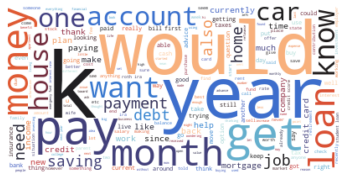

In [96]:
plt.figure(figsize=(6,6))

text_1 = ' '.join(i for i in clean_df.loc[clean_df['subreddit_personalfinance'] == 1]['all_text'])

wordcloud_1 = WordCloud(stopwords=all_stopwords, 
                      background_color="white",
                      colormap='icefire',
                      max_words=200
                     ).generate(text_1)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

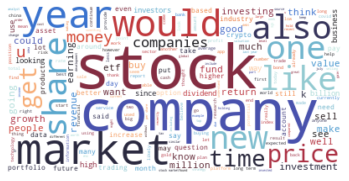

In [98]:
plt.figure(figsize=(6,6))

text_2 = ' '.join(i for i in clean_df.loc[clean_df['subreddit'] == 'investing']['all_text'])

wordcloud_2 = WordCloud(stopwords=all_stopwords, 
                        background_color="white",
                        colormap='icefire',
                        max_words=200
                       ).generate(text_2)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")
plt.show()

**Observations**

1. We observe that several words found with large relative size to be present in both word clouds. These include the words 'would', 'year' and 'one'.
2. However, we also note the differences in the two word clouds. The subreddit r/investing has more focus words such as 'stock', 'company' and 'market', which are not present in the r/personalfinance wordcloud. 
3. Similarly, some focus words found in r/personalfinance suc as 'loan', 'k', 'money' and 'account' are not found to be as large (or at all) in the r/investing wordcloud.
4. These focus words provide a great amount of predictive power. These findings suggest that the two subreddits may be able to produce a good predictive model.

### Word Count

We visualize the difference in word count for both subreddits in the graph below. The following are the steps we took to create the visualization:

    1. Create and apply function for word count
    2. Create word count visualization

**Note: We have limited the x-range due to a long tail in both subreddits**

In [12]:
# Step 1: Create and apply function for word count:

def make_word_count(row):
    row['word_count'] = len(row['selftext'])
    return row

clean_df = clean_df.apply(make_word_count, axis=1)

<Figure size 432x3600 with 0 Axes>

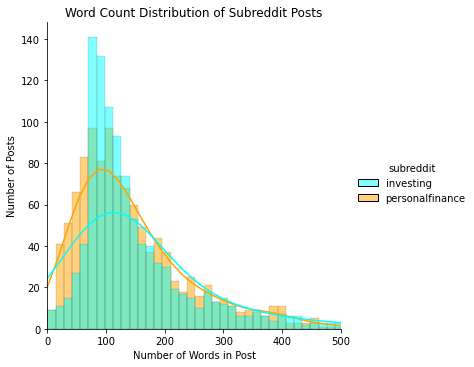

In [13]:
# Step 2: Word count visualization

plt.figure(figsize=(6,50))
sns.displot(
    x=clean_df['word_count'],
    hue=clean_df['subreddit'],
    palette=['cyan', 'orange'],
    bins=250,
    kde=True
);
plt.xlim(0, 500)
plt.title('Word Count Distribution of Subreddit Posts')
plt.ylabel('Number of Posts')
plt.xlabel('Number of Words in Post');

**Observations**:

1. The distribution of word count is unimodal with a peak at the 80-120 word range in both subreddits.
2. The high peak in the r/investing subreddit shown by the drastic increase in frequency in the (80-100) as compared to the bin before it (70-80) can be explained as a result of a minimum word count for subreddit. It appears that in most cases, reddit users who are not long-time members of or active in the subreddit is restricted by a minimum word count threshold set by the subreddit's moderators.
3. In the r/investing subreddit, the restriction in the minimum number of words used in the posts seem have incentivized posters to meet the word count. 
4. Although the peak in word count in the r/personalfinance subreddit is similar to the r/investing subreddit, there is a much flatter top in the r/personalfinance subreddit. This appears to be a more natural distribution of length of posts.
5. The distribution is skewed right, with a very long tail. This suggests that while most posts are concise in nature, outlier posts with more word counts are also present. 
6. The unnatural distribution of posts in r/investing due to the imposed minimum word count restriction seems to negatively affect the kde. As such, using a kde to predict the frequency of word count per post may not provide sufficient predictive power for future posts.

## Ngram Visualization

### Create DataFrame and Function

Prior to ngram visualization, we would note that the frequency of the top-20 unigram far exceed that of the top-20 bigrams. As such, the frequency of occurence for the top bigram is smaller than the top 20th unigram. The same is true when comparing the frequency of bigrams to trigram. Therefore, if we set a different value for minimum and maximum ngram range, our top-20 results will only be words from the minimum ngram range.
Hence, we set our minimum and maximum ngram range to be equal. This way, we obtain 1-word, 2-word, and 3-word ngrams separately.

Below are the steps we will take for the initial step of visualization: 

    1. We create separate series' for each subreddit so that we can display the most frequent unigram, bigram and trigram for each subreddit and compare the results.
    2. Create function for Count Vectorizer Visualization
    3. Create function for TF-IDF Vectorizer Visualization

In [14]:
# Step 1: Create separate series for each subreddit
visual_personalfinance = clean_df.loc[clean_df['subreddit_personalfinance'] == 1, 'tok_snow_all_text']
visual_investing = clean_df.loc[clean_df['subreddit_personalfinance'] == 0, 'tok_snow_all_text']

In [15]:
# Step 2: Create function for CVEC Vectorizer Visualization
def cvec_ngram(range_value):

    # Instantiate Vectorizer
    cvec_visual = CountVectorizer(ngram_range=(range_value, range_value))
    
    # Creating dataframe based on vectorizer
    personalfinance_visual = cvec_visual.fit_transform(visual_personalfinance)
    personalfinance_visual_df = pd.DataFrame(personalfinance_visual.todense(),
                                             columns=cvec_visual.get_feature_names())
    investing_visual = cvec_visual.fit_transform(visual_investing)
    investing_visual_df = pd.DataFrame(investing_visual.todense(),
                                       columns=cvec_visual.get_feature_names())
    
    # Plotting bar graph
    plt.figure(figsize=(9, 4))
    
    plt.subplot(1, 2, 1)
    personalfinance_visual_df.sum().sort_values(
        ascending=False).head(10).plot(kind='barh');
    plt.title('Top 10 Word(s) in r/personalfinance (CVEC)')
    plt.ylabel('Word(s)')
    plt.xlabel('Frequency (CVEC)')

    plt.subplot(1, 2, 2)
    investing_visual_df.sum().sort_values(
        ascending=False).head(10).plot(kind='barh');
    plt.title('Top 10 Word(s) in r/investing (CVEC)')
    plt.ylabel('Word(s)')
    plt.xlabel('Frequency (CVEC)')
    
    plt.tight_layout()

In [16]:
# Step 3: Create function for TF-IDF Vectorizer Visualization
def tvec_ngram(range_value):

    # Instantiate Vectorizer
    tvec_visual = TfidfVectorizer(ngram_range=(range_value, range_value))
    
    # Creating dataframe based on vectorizer
    personalfinance_visual = tvec_visual.fit_transform(visual_personalfinance)
    personalfinance_visual_df = pd.DataFrame(personalfinance_visual.todense(),
                                             columns=tvec_visual.get_feature_names())
    investing_visual = tvec_visual.fit_transform(visual_investing)
    investing_visual_df = pd.DataFrame(investing_visual.todense(),
                                       columns=tvec_visual.get_feature_names())
    
    # Plotting bar graph
    plt.figure(figsize=(9, 4))
    
    plt.subplot(1, 2, 1)
    personalfinance_visual_df.sum().sort_values(
        ascending=False).head(10).plot(kind='barh');
    plt.title('Top 10 Word(s) in r/personalfinance (TVEC)')
    plt.ylabel('Word(s)')
    plt.xlabel('Frequency (TVEC)')

    plt.subplot(1, 2, 2)
    investing_visual_df.sum().sort_values(
        ascending=False).head(10).plot(kind='barh');
    plt.title('Top 10 Word(s) in r/investing (TVEC)')
    plt.ylabel('Word(s)')
    plt.xlabel('Frequency (TVEC)')
    
    plt.tight_layout()

### Unigrams

We tabulate our findings below. Some values have been modified for better readability.

Words found in all four graphs are colorized according to the common word for easier visualization.

|Rank|Model: CVEC<br>Sub: r/personalfinance</br>|Model: TVEC<br>Sub: r/personalfinance</br>|Model: CVEC<br>Sub: r/investing</br>|Model: TVEC<br>Sub: r/investing</br>|
|----|-----------|-----------|-----------|-----------|
|1|<font color='blue'>Year</font>|Credit|Company|Stock|
|2|<font color='red'>Would</font>|<font color='blue'>Year</font>|Stock|Company|
|3|Month|Loan|Market|Market
|4|Pay|Pay|<font color='blue'>Year</font>|<font color='blue'>Year</font>|
|5|Get|Month|Like|Share|
|6|Credit|Account|Price|Like|
|7|Loan|<font color='red'>Would</font>|Share|<font color='red'>Would</font>|
|8|Account|Save|<font color='red'>Would</font>|Fund|
|9|Any|Get|Buy|Money|
|10|Money|Car|Use|Price|

We note several observations from our unigrams.

1. 'Would' appears to be a common word in all instance of unigrams. This is most likely due to its nature as a stopword. However, we withhold dropping this word due to possible permutations in contextually.
2. 'Year' is also a common word. This suggests that in both subreddits, time is a factor of concern.
3. More notably, the two subreddits seem to have a difference in the nature of words used. In r/personalfinance, it appears that there is a greater usage of inward-looking words such as 'Credit', 'Loan', and 'Pay' (salary), while in r/investing, more outward-looking words such as 'Company', 'Stock', and 'Market' are used.
4. We note that the relatively small number of similar unigrams in the top 10 unigrams used provide for greater distinguishability between the two subreddits, which may allow for greater predictive power of our model.

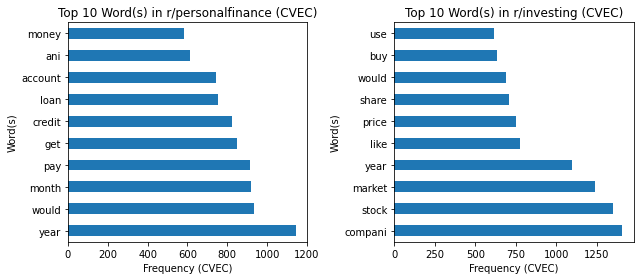

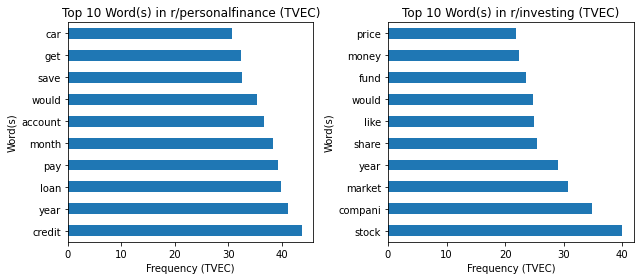

In [17]:
cvec_ngram(1)
tvec_ngram(1)

### Bigrams

We tabulate our findings below. Some values have been modified for better readability.

Bigrams found in all four graphs are colorized according to the common bigram for easier visualization.

|Rank|Model: CVEC<br>Sub: r/personalfinance</br>|Model: TVEC<br>Sub: r/personalfinance</br>|Model: CVEC<br>Sub: r/investing</br>|Model: TVEC<br>Sub: r/investing</br>|
|----|-----------|-----------|-----------|-----------|
|1|Credit Card|Credit Card|Long Term|Long Term|
|2|Student Loan|<font color='blue'>Roth IRA</font>|Last Year|Stock Market
|3|Credit Score|Credit Score|Stock Market|<font color='blue'>Roth IRA</font>|
|4|<font color='blue'>Roth IRA</font>|Student Loan|Per Share|Index Fund|
|5|Next Year|Interest Rate|Yahoo Finance|Real Estate|
|6|Interest Rate|Savings Account|Real Estate|Last Year|
|7|Any Advice|Any Advice|Second Quarter|Per Share|
|8|Year Old|Year Old|Year (over) Year|Does Anyone|
|9|Emergency Fund|Next Year|Cash Flow|Mutual Fund|
|10|Savings Account|Emergency Fund|<font color='blue'>Roth IRA</font>|Interest Rate|

Similarly, we note some observations from the top bigrams:

1. Roth IRA is a common popular bigram in the four graphs. A [Roth IRA](https://www.investopedia.com/terms/r/rothira.asp) is a retirement account funded with after-tax dollars. We believe that it is a popular word used in both subreddits due to its characteristics as a tax-free retirement account, which is attractive for both personal finance and investments.
2. Similarly, there is a distinction between the nature of the words used. The 'investing' subreddit again places more focus on outward-facing matters such as 'stock market' and 'real estate', while the words useed in the 'personalfinance' subreddit places greater focus on one's inward-facing circumstances such as 'student loan' and 'savings account'.
3. We observe that 'credit card', the top bigram in the subreddit 'personalfinance' has a significantly higher usage frequency as compared to the second highest bigram. Visually, by count vectorizer, it is used almost 2x as much as the second highest bigram (~280 vs ~150). When regularized using TF-IDF vectorizer, the usage frequency of 'credit card' is still over 25% ahead of the next bigram. This suggests that the presence or absence of the bigram 'credit card' may play a big role in the predictive value of our model.
4. We see the same occurrence in the subreddit r/investing, where 'long term' has the highest frequency when vectorized by both CVEC and TF-IDF. 
5. We note that the difference between top bigrams in the two subreddits allow for greater predictive power of our model due to its greater distinguishability.

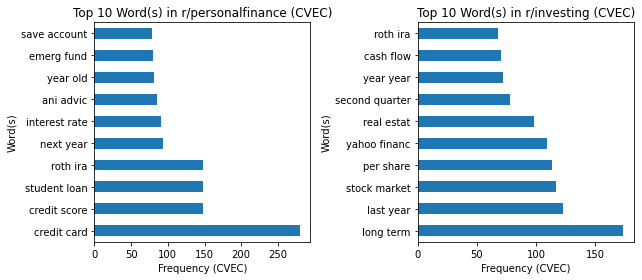

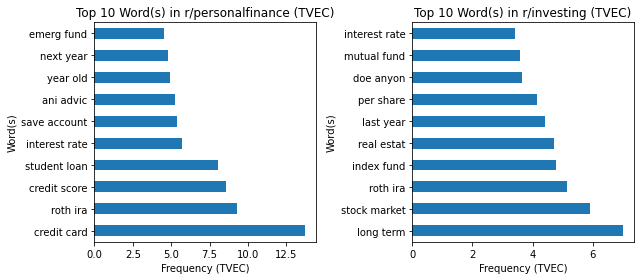

In [18]:
cvec_ngram(2)
tvec_ngram(2)

### Trigrams

We tabulate our findings below. Some values have been modified for better readability.

Bigrams found in all four graphs are colorized according to the common bigram for easier visualization.

|Rank|Model: CVEC<br>Sub: r/personalfinance</br>|Model: TVEC<br>Sub: r/personalfinance</br>|Model: CVEC<br>Sub: r/investing</br>|Model: TVEC<br>Sub: r/investing</br>|
|----|-----------|-----------|-----------|-----------|
|1|Credit Card Debt|Credit Card Debt|Buy Yahoo Finance|Earnings Per Share|
|2|Start New Job|Start New Job|Recommend Buy Yahoo|Does Anyone Know|
|3|Long Story Short|Long Story Short|Yahoo Finance Recommend|Free Cash Flow|
|4|Pay Student Loan|Pay Student Loan|Weiss Rating Recommend|Billion vs Billion|
|5|Would Greatly Appreciate|Would Greatly Appreciate|InvestorObserver Overall Score|Sell Covered Calls|
|6|Capital Gain Tax|Does Anyone (know) Any|Finance Target Price|Revenue Billion vs|
|7|Student Loan Debt|Student Loan Debt|Price Book Ratio|Does Anyone (know) any|
|8|Vanguard Target Retirement|Capital Gain Tax|Yahoo Finance Target|Increase Year (over) Year|
|9|Pay Credit Card|Pay Credit Card|Valuation Valuation Entry|Capital Gain Tax
|10|Work Full Time|Work Full Time|Yahoo Finance Year|Vanguard Roth IRA|

We note several observations from comparing our trigrams. 

1. We note that there are no similar trigrams appearing in all four diagrams.
2. The personalfinance subreddit pays greater attention to personal circumstances such as personal liabilities (student loan debt, pay (_sic_) student loan, pay (_sic_) credit card). We note that there is also a greater focus on personal income (start new job, work full time).
3. Meanwhile, the investing subreddit pays greater focus towards institutional characters, with mentions on 'InvestorObserver', 'Yahoo' and 'Weiss'. There is also a greater focus on a company's metrics and financial targets, with metrics such as 'Free Cash Flow', 'Valuation Valuation (_sic_) Entry', and 'Earnings per Share'.
4. We note that the same observation on the top bigram in r/personalfinance appears in a similar fashion in the top trigram in the same subreddit.
5. Comparing the CVEC and TVEC results of r/investing, 'earnings per share', a popular metric used to evaluate a company's implied market value and its relative over/undervaluation, does not appear to be present in the top 10 words in r/investing when vectorized using CVEC. However, it is the top trigram when regularization is applied using TF-IDF Vectorizer. This suggests that although it is less used in terms of true count, it appears to play greater weight on the post within the subreddit.

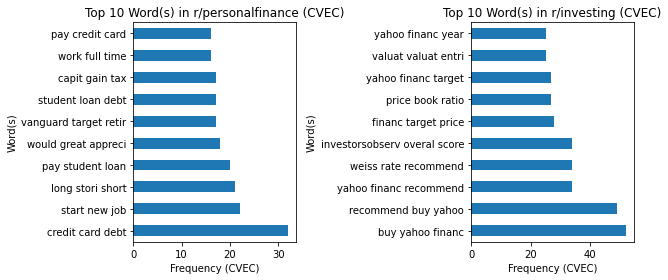

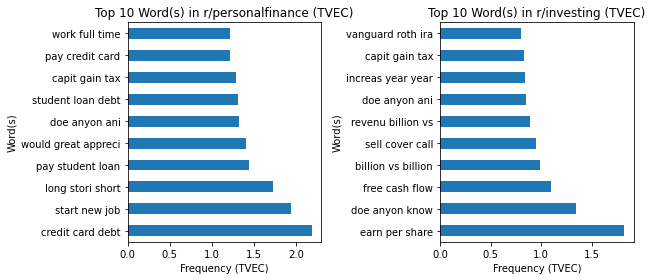

In [19]:
cvec_ngram(3)
tvec_ngram(3)

### Concluding Remarks for Ngram Visualization

We aggregate our findings through our unigram, bigram and trigram visualization. We note that among the top 10 words used in unigrams, bigrams and trigrams, there is little similarity between the two subreddits. The large proportion of difference in ngram usage frequency suggests that our tokens will provide a significant predictive value in our model.

In observing our bigrams and trigrams, we gained a greater contextual understanding of the difference in the nature of the subreddits. As shown in the table below, the focus of r/personalfinance seems to on internal circumstances and is more preservative by nature whereas the focus of r/investing is more external opportunities and seeking gains. For instance, r/personalfinance focuses on an individual's personal financial condition such as how much debt they have and how much savings they have. Meanwhile, r/investing has a greater focus on opportunities to deploy funds for more gain, with bigrams and trigrams focusing more on an investment target's (public company in the stock market) financial metrics and institutional view on its performance (price targets).

We also note the word choice in r/investing, 'real estate'. In the context of personal finance, 'real estate' is more commonly referred to as 'housing', 'residential property' or other forms of words for 'shelter'. Granted, 'real estate' covers more than simply housing. However, by using the term 'real estate', participants in the r/investing subreddit are more inclined on using its components, including 'residential property' or 'housing' more as an investment opportunity and less for personal use.

|Subreddit|ngram|Description|Nature (Internal/External)|
|---------|-----|-----------|--------------------------|
|r/personalfinance|Student Loan|Personal Debt|Internal|
||Savings Account|Personal Asset|Internal|
||Credit Score|Personal Credit Rating|Internal|
||Emergency Fund|Personal Safety Net|Internal|
||Pay Credit Card|Personal Debt|Internal|
||Start New Job|Personal Job Status|Internal|
||Work Full Time|Personal Job Status|Internal|
|r/investing|Stock Market|Public Company Stocks|External|
||Real Estate|Investment Sector|External|
||Per Share|Financial Metric|External|
||Cash Flow|Financial Metric|External|
||Price Book Ratio|Financial Metric|External|
||Earnings per Share|Financial Metric|External|
||Sell Covered Calls|Financial Instrument|External|
||Yahoo Finance Target|Institutional Recommendation|External|
||InvestorObserver Overall Score|Institutional Recommendation|External|


## Initiate X and y

Here, we initiate X and y to be used in the modeling section.



In [20]:
# X and y are both Series
X = clean_df['tok_snow_all_text']
y = clean_df['subreddit_personalfinance']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=42,
                                                  stratify=y)

We create several models and confusion matrices based on different types of vectorizers and classifiers and obtain several metrics:

Vectorizers:

    1. CountVectorizer (CVEC)
    2. Term Frequency–Inverse Document Frequency Vectorizer (TFIDF)

Models/Classifiers:

    1. Baseline Model
    2. Logistic Regression
    3. KNeighbors Classifier
    4. Multinomial Naive Bayes (NB)
    5. Decision Tree Classifier
    6. Bagging (Bootstrap Aggregating)
    7. Random Forests Classifier

Metrics:

    1. Training/Testing Score
    2. Accuracy
    3. Misclassification
    4. Sensitivity
    5. Specificity
    6. Precision

## Basic Model

We use the higher probability of 'subreddit' as the baseline. Obtaining the probability distribution, we find that given a random text, choosing 'personalfinance' as the subreddit gives us a 50.6% chance of being correct. Hence, our baseline model is 50.6%.

|Model|Accuracy|
|-----|--------|
|Basic|50.6%|

In [21]:
clean_df['subreddit_personalfinance'].value_counts(normalize=True)

1    0.505553
0    0.494447
Name: subreddit_personalfinance, dtype: float64

## Logistic Regression

In this section, we create a logistic regression model using CVEC and TF-IDF Vectorizer and tabulate our findings. We first create a function to call on our models based on the format 'gs_(vectorizer)\_(model name)'

In [22]:
def model(gs_vectorizer_model):
    gs_vectorizer_model.fit(X_train, y_train)
    model_preds = gs_vectorizer_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, model_preds).ravel()
    print(f'Best Score:                                {round(gs_vectorizer_model.best_score_, 3)*100}%')
    print(f'Train Score:                               {round(gs_vectorizer_model.score(X_train, y_train), 3)*100}%')
    print(f'Accuracy (Test Score):                     {round((tp+tn)/(tn+fp+fn+tp),3)*100}%')
    print(f'Misclassification:                         {round(1-(tp+tn)/(tn+fp+fn+tp),3)*100}%')
    print(f'Sensitivity / True Positive Rate / Recall: {round((tp)/(tp+fn),3)*100}%')
    print(f'Specificity / True Negative Rate:          {round(tn/(tn+fp),3)*100}%')
    print(f'Precision / Positive Predictive Value:     {round(tp/(tp+fp),3)*100}%')
    print(f'Best Parameters:                           {gs_vectorizer_model.best_params_}')
    plot_confusion_matrix(gs_vectorizer_model, 
                          X_test, y_test, 
                          cmap='Blues', 
                          values_format='d',
                          display_labels=['r/investing', 'r/personalfinance']
                         );

###  CountVectorizer Logistic Regression

We used Pipeline and GridSearchCV to perform a CVEC logistic regression model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the Accuracy and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|CVEC Max Features|1000, 2000, 3000<br>4000, 5000</br>|4000|
|CVEC Ngram Range|(1, 1), (1, 2)<br>(1, 3), (1, 4)</br>|(1, 2)|
|Logit CV|5, 10, 15, 20, 25|10|

|Metric|Value|
|------|-----|
|Best Accuracy|89.0%|
|Train Accuracy|96.4%|
|Test Accuracy|89.7%|
|Misclassification|10.3%|
|Sensitivity|92.3%|
|Specificity|87.1%|
|Precision|88.0%|


Best Score:                                89.0%
Train Score:                               96.39999999999999%
Accuracy (Test Score):                     89.7%
Misclassification:                         10.299999999999999%
Sensitivity / True Positive Rate / Recall: 92.30000000000001%
Specificity / True Negative Rate:          87.1%
Precision / Positive Predictive Value:     88.0%
Best Parameters:                           {'cvec__max_features': 4000, 'cvec__ngram_range': (1, 2), 'logit__cv': 10, 'logit__n_jobs': -1, 'logit__random_state': 42}


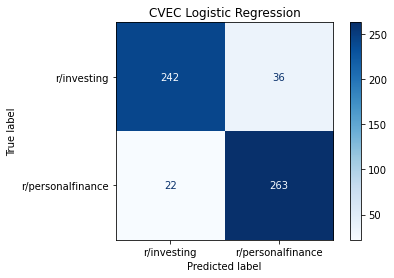

In [23]:
cvec = CountVectorizer()
logit = LogisticRegressionCV()

pipe_cvec_logit = Pipeline([
    ('cvec', cvec),
    ('logit', logit)])

pipe_cvec_logit_params = {
    'cvec__max_features': [4000],
    'cvec__ngram_range': [(1,2)],
    'logit__n_jobs': [-1],
    'logit__random_state': [42],
    'logit__cv': [10]}

gs_cvec_logit = GridSearchCV(
    estimator=pipe_cvec_logit,
    param_grid=pipe_cvec_logit_params,
    cv=5)

model(gs_cvec_logit)
plt.title('CVEC Logistic Regression');

### TF-IDF Vectorizer Logistic Regression

We used Pipeline and GridSearchCV to perform a TVEC logistic regression model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the $R^2$ and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|CVEC Max Features|1000, 2000, 3000<br>4000, 5000</br>|3000|
|CVEC Ngram Range|(1, 1), (1, 2), (1, 3)<br>(1, 4), (1, 5), (1, 6)</br>|(1, 4)|
|Logit CV|5, 10, 15, 20, 25|15|

|Metric|Value|
|------|-----|
|Best Accuracy|90.0%|
|Train Accuracy|91.9%|
|Test Accuracy|90.8%|
|Misclassification|9.2%|
|Sensitivity|91.6%|
|Specificity|89.9%|
|Precision|90.3%|

Best Score:                                90.0%
Train Score:                               91.9%
Accuracy (Test Score):                     90.8%
Misclassification:                         9.2%
Sensitivity / True Positive Rate / Recall: 91.60000000000001%
Specificity / True Negative Rate:          89.9%
Precision / Positive Predictive Value:     90.3%
Best Parameters:                           {'logit__cv': 15, 'logit__n_jobs': -1, 'logit__random_state': 42, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 4)}


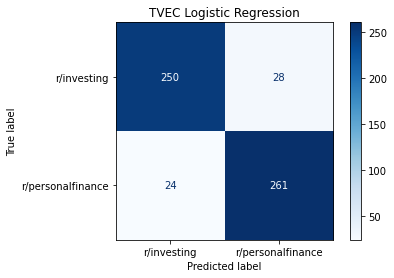

In [24]:
tvec = TfidfVectorizer()
logit = LogisticRegressionCV()

pipe_tvec_logit = Pipeline([
    ('tvec', tvec),
    ('logit', logit)])

pipe_tvec_logit_params = {
    'tvec__max_features': [3000],
    'tvec__ngram_range': [(1,4)],
    'logit__n_jobs': [-1],
    'logit__random_state': [42],
    'logit__cv': [15]
}

gs_tvec_logit = GridSearchCV(
    estimator=pipe_tvec_logit,
    param_grid=pipe_tvec_logit_params,
    cv=5)

model(gs_tvec_logit)
plt.title('TVEC Logistic Regression');

### Comparing Logistic Regression Results

We tabulate the best parameters found:

|Parameter|Best CVEC|Best TVEC|
|---------|---------|---------|
|Vectorizer Max Features|4000|3000|
|Vectorizer Ngram Range|(1, 2)|(1, 4)|
|Logistic Regression CV|10|15|

**Observations:**

1. Observing max features used, our TVEC model uses less features than our CVEC model. The difference in max features used is due to the penalization of terms using TVEC which enables a greater weight to be applied to focus words in each subreddit.
2. We find that the inclusion of trigrams and quadrigrams in our TVEC model is provides accretive prediction power as compared to CVEC, which uses only unigrams and bigrams.

Tabulating our results gives us:


|Model|Vectorizer|Best Accuracy|Train Accuracy|Test Accuracy|Sensitivity|Specificity|Precision|
|-----|----------|----------|-----------|--------------------|-----------|-----------|---------|
|Logistic Regression|CVEC|89.0%|<font color='blue'>96.4%</font>|89.7%|<font color='blue'>92.3%</font>|87.1%|88.0%|
|Logistic Regression|TVEC|<font color='blue'>90.0%</font>|91.9%|<font color='blue'>90.8%</font>|91.6%|<font color='blue'>89.9%</font>|<font color='blue'>90.3%</font>|

**Note: We colorized the better value <font color='blue'>blue</font> for easier readability.**

**Observations:**

1. Overall, we find that a logistic regression gives us a great results on our 4 main metrics: Accuracy, Sensitivity, Specificity and Precision.
1. Based on our results, a TF-IDF vectorizer had scored better on 3 out of 4 of our metrics.
2. While CVEC train accuracy is significantly better than TVEC train accuracy, our CVEC accuracy (test accuracy) is lower than TVEC accuracy. Comparing CVEC train accuracy and test accuracy, we find a material drop in accuracy. This suggests that there is a signifcant amount of noise present in our CVEC model that is reduced in our TVEC model.
3. The effect of penalizing using TF-IDF seems to have provided a better predictive value than simply using a CVEC Vectorizer.
4. Based on our findings, a TF-IDF vectorized logistic regression model performs better than a Count Vectorized logistic regression model.

**Conclusion: Better Vectorizer: TVEC**


## MultiNomial Naive Bayes

In this section, we create two Multinomial Naive Bayes models by using different vectorizers: CountVectorizer and TFIDF Vectorizer.

### CountVectorizer Naive Bayes

We used Pipeline and GridSearchCV to perform a CVEC Multinomial Naive Bayes model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the Accuracy and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|CVEC Max Features|1000, 2000, 3000, 4000<br>5000, 6000, 7000</br>|5000|
|CVEC Ngram Range|(1, 1), (1, 2), (1, 3), (1, 4)|(1, 2)|

|Metric|Value|
|------|-----|
|Best Accuracy|88.9%|
|Train Accuracy|91.8%|
|Test Accuracy|90.6%|
|Misclassification|9.4%|
|Sensitivity|97.9%|
|Specificity|83.1%|
|Precision|85.6%|

Best Score:                                88.9%
Train Score:                               91.8%
Accuracy (Test Score):                     90.60000000000001%
Misclassification:                         9.4%
Sensitivity / True Positive Rate / Recall: 97.89999999999999%
Specificity / True Negative Rate:          83.1%
Precision / Positive Predictive Value:     85.6%
Best Parameters:                           {'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}


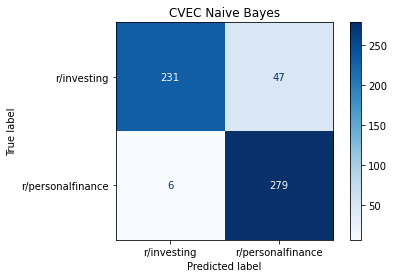

In [25]:
# Instantiate CountVectorizer() and MultinomialNB()
cvec = CountVectorizer()
nb = MultinomialNB()

pipe_cvec_nb = Pipeline([
    ('cvec', cvec),
    ('nb', nb)])

pipe_cvec_nb_params = {
    'cvec__stop_words': ['english'],
    'cvec__max_features': [5000],
    'cvec__ngram_range': [(1, 2)]
}

# Instantiate GridSearchCV.
gs_cvec_nb = GridSearchCV(
    estimator=pipe_cvec_nb, 
    param_grid=pipe_cvec_nb_params, 
    cv=5)

model(gs_cvec_nb)
plt.title('CVEC Naive Bayes');

### TF-IDF Vectorizer Naive Bayes 

We used Pipeline and GridSearchCV to perform a TVEC Multinomial Naive Bayes model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the Accuracy and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|CVEC Max Features|1000, 2000, 3000, 4000, 5000<br>6000, 7000, 8000, 9000</br>|7000|
|CVEC Ngram Range|(1, 1), (1, 2), (1, 3), (1, 4)|(1, 3)|

|Metric|Value|
|------|-----|
|Best Accuracy|90.5%|
|Train Accuracy|94.0%|
|Test Accuracy|91.7%|
|Misclassification|8.3%|
|Sensitivity|95.8%|
|Specificity|87.4%|
|Precision|88.6%|

Best Score:                                90.5%
Train Score:                               94.0%
Accuracy (Test Score):                     91.7%
Misclassification:                         8.3%
Sensitivity / True Positive Rate / Recall: 95.8%
Specificity / True Negative Rate:          87.4%
Precision / Positive Predictive Value:     88.6%
Best Parameters:                           {'tvec__max_features': 7000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}


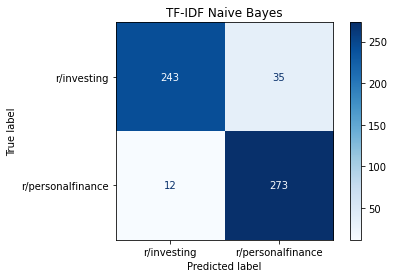

In [26]:
tvec = TfidfVectorizer()
nb = MultinomialNB()

# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec_nb = Pipeline([
    ('tvec', tvec),
    ('nb', nb)
])

pipe_tvec_nb_params = {
    'tvec__stop_words': ['english'],
    'tvec__max_features': [7000],
    'tvec__ngram_range': [(1, 3)],
}

# Instantiate GridSearchCV.
gs_tvec_nb = GridSearchCV(
    estimator=pipe_tvec_nb,
    param_grid=pipe_tvec_nb_params,
    cv=5)

model(gs_tvec_nb)
plt.title('TF-IDF Naive Bayes');

### Comparing Naive Bayes Results

We tabulate the best parameters found:

|Parameter|Best CVEC|Best TVEC|
|---------|---------|---------|
|Vectorizer Max Features|5000|7000|
|Vectorizer Ngram Range|(1, 2)|(1, 3)|


**Observations:**

1. We find that TVEC model had used trigrams in addition to the unigrams and bigrams used in CVEC.
2. We find that more features were used in the TVEC model, possibly due to the inclusion of trigrams.
3. Although more features were used in our TVEC model, we do not see a negative impact on overfitting. Instead, it appears that using more features in combination with a trigram had provided greater predictive power.

Tabulating our results gives us:

**Note: We colorized the better value <font color='blue'>blue</font> for easier readability.**

|Model|Vectorizer|Best Accuracy|Train Accuracy|Test Accuracy|Sensitivity|Specificity|Precision|
|-----|----------|----------|-----------|---------------------|-----------|-----------|---------|
|Naive Bayes|CVEC|88.9%|91.8%|90.6%|<font color='blue'>97.9%</font>|83.1%|85.6%|
|Naive Bayes|TVEC|<font color='blue'>90.5%</font>|<font color='blue'>94.0%</font>|<font color='blue'>91.7%</font>|95.8%|<font color='blue'>87.4%</font>|<font color='blue'>88.6%</font>|

**Observations:**

1. Overall, we find that a naive bayes model gives us a favorable results on our 4 main metrics: Accuracy, Sensitivity, Specificity and Precision.
2. Based on our results, a TF-IDF vectorizer had scored better on 3 out of 4 of our metrics.
3. While CVEC train accuracy is better than TVEC train accuracy, CVEC test accuracy is lower than TVEC test accuracy. This suggests that the usage of a higher number of features combined with the usage of a trigram had provided greater predictive power as compared to the CVEC model without negatively impacting our model. As stated above, the usage of more features in combination with a trigram had provided greater predictive value to our model.
4. Based on our findings, a TF-IDF vectorized naive bayes model performs better than a Count Vectorized naive bayes model.

**Conclusion: Better Vectorizer: TVEC**


## Decision Tree

### CountVectorizer Decision Tree

We used Pipeline and GridSearchCV to perform a CVEC Decision Tree Model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the Accuracy and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|CVEC Max Features|1000, 2000, 3000, 4000<br>5000, 6000, 7000, 8000</br>|7000|
|CVEC Ngram Range|(1, 1), (1, 2), (1, 3)<br>(1, 4), (1, 5), (1, 6)</br>|(1, 4)|
|Decision Tree Maximum Depth|10, 20, 30, 40<br>50, 60, 70, 80</br>|60|
|Decision Tree Max Features|0.10, 0.15, 0.20, 0.25|0.15|

|Metric|Value|
|------|-----|
|Best Accuracy|80.7%|
|Train Accuracy|100.0%|
|Test Accuracy|81.3%|
|Misclassification|18.7%|
|Sensitivity|85.6%|
|Specificity|77.0%|
|Precision|79.2%|

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score:                                80.7%
Train Score:                               100.0%
Accuracy (Test Score):                     81.3%
Misclassification:                         18.7%
Sensitivity / True Positive Rate / Recall: 85.6%
Specificity / True Negative Rate:          77.0%
Precision / Positive Predictive Value:     79.2%
Best Parameters:                           {'cvec__max_features': 7000, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': 'english', 'dt__max_depth': 60, 'dt__max_features': 0.15, 'dt__random_state': 42}


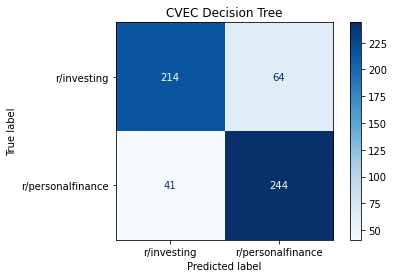

In [27]:
dt = DecisionTreeClassifier()

pipe_cvec_dt = Pipeline([
    ('cvec', cvec),
    ('dt', dt)
])

pipe_cvec_dt_params = {
    'cvec__stop_words': ['english'],
    'cvec__max_features': [7000],
    'cvec__ngram_range': [(1,4)],
    'dt__max_depth': [60],
    'dt__max_features': [0.15],
    'dt__random_state': [42],
}
gs_cvec_dt = GridSearchCV(
    estimator=pipe_cvec_dt,
    param_grid=pipe_cvec_dt_params,
    cv = 5,
    verbose = 1
)

model(gs_cvec_dt)
plt.title('CVEC Decision Tree');

### TF-IDF Vectorizer Decision Tree

We used Pipeline and GridSearchCV to perform a TVEC Decision Tree Model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the Accuracy and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|TVEC Max Features|1000, 2000, 3000, 4000, 5000, 6000|3000|
|TVEC Ngram Range|(1, 1), (1, 2), (1, 3), (1, 4)|(1, 2)|
|Decision Tree Maximum Depth|10, 20, 30, 40, 50|30|
|Decision Tree Max Features|0.10, 0.15, 0.20, 0.25|0.15|

|Metric|Value|
|------|-----|
|Best Accuracy|79.3%|
|Train Accuracy|97.5%|
|Test Accuracy|78.7%|
|Misclassification|21.3%|
|Sensitivity|80.7%|
|Specificity|76.6%|
|Precision|78.0%|

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score:                                79.3%
Train Score:                               97.5%
Accuracy (Test Score):                     78.7%
Misclassification:                         21.3%
Sensitivity / True Positive Rate / Recall: 80.7%
Specificity / True Negative Rate:          76.6%
Precision / Positive Predictive Value:     78.0%
Best Parameters:                           {'dt__max_depth': 30, 'dt__max_features': 0.15, 'dt__random_state': 42, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


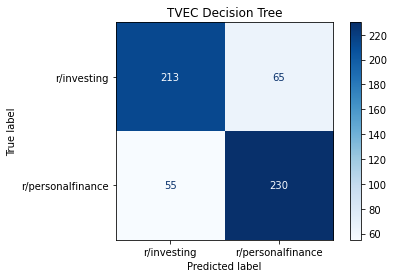

In [28]:
dt = DecisionTreeClassifier()

pipe_tvec_dt = Pipeline([
    ('tvec', tvec),
    ('dt', dt)
])

pipe_tvec_dt_params = {
    'tvec__stop_words': ['english'],
    'tvec__max_features': [3000],
    'tvec__ngram_range': [(1,2)],
    'dt__max_depth': [30],
    'dt__max_features': [0.15],
    'dt__random_state': [42],
}

gs_tvec_dt = GridSearchCV(
    estimator=pipe_tvec_dt,
    param_grid=pipe_tvec_dt_params,
    cv = 5,
    verbose = 1
)

model(gs_tvec_dt)
plt.title('TVEC Decision Tree');

### Comparing Decision Tree Results

Tabulating our parameters gives us:

|Parameter|Best CVEC|Best TVEC|
|---------|---------|---------|
|Vectorizer Max Features|7000|3000|
|Vectorizer Ngram Range|(1, 4)|(1, 2)|
|Decision Tree Maximum Depth|60|30|
|Decision Tree Max Features|0.15|0.15|

**Observations:**

1. We observe that there is a much lesser max features used in our TVEC model as compared to our CVEC model. This appears to be the effect of penalization of terms using TVEC which enables a greater weight to be applied to focus words in each subreddit.
2. CVEC max features may also be higher due to a decision tree model's nature of being noisy learners. As such, decision trees tend to skew towards using more features than compared to our other models.
3. Being noisy learners also explains why a decision tree uses a much higher depth on a CVEC model as compared to a TVEC model which has had common words penalized to provide greater weight to focus words.

Tabulating our results gives us:

|Model|Vectorizer|Best Accuracy|Train Accuracy|Test Accuracy|Sensitivity|Specificity|Precision|
|-----|----------|----------|-----------|---------------------|-----------|-----------|---------|
|Decision Tree|CVEC|<font color='blue'>80.7%</font>|<font color='blue'>100%</font>|<font color='blue'>81.3%</font>|<font color='blue'>85.6%</font>|<font color='blue'>77.0%</font>|<font color='blue'>79.2%</font>|
|Decision Tree|TVEC|79.3%|97.5%|78.7%|80.7%|76.6%|78.0%|

**Note: We colorized the better value <font color='blue'>blue</font> for easier readability.**


**Observations:**

1. Our initial observation finds that a decision tree scored favorably in our metrics: Accuracy, Sensitivity, Specificity and Precision.
2. Based on our results, our count vectorizer model had scored better on all 4 of our metrics.
3. In both models, there is a large range between the train and test accuracy, which suggests that we may be suffering from a significant amount of underfitting to our test accuracy.
4. In conclusion, although a decision tree may have scored favorably in our metrics, the significant amount of overfitting in our training set as compared to our testing set suggests that our model may not have much predictive value and may score highly unfavorably to a blind test set.

**Conclusion: Better Vectorizer: CVEC, but we should try other decision tree based models instead**

## Bagging Model (Bootstrap Aggregating Decision Tree)

### CountVectorizer Bagging Model

We used Pipeline and GridSearchCV to perform a CVEC Bagging Model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the Accuracy and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|CVEC Max Features|1000, 2000, 3000<br>4000, 5000</br>|3000|
|CVEC Ngram Range|(1, 1), (1, 2)<br>(1, 3)(1, 4)</br>|(1, 2)|
|Bagging Max Samples|0.25, 0.5, 0.75, 1.0|1.0|
|Bagging Max Features|0.10, 0.15, 0.20, 0.25<br>0.30, 0.35, 0.4</br>|0.35|

|Metric|Value|
|------|-----|
|Best Accuracy|86.4%|
|Train Accuracy|99.6%|
|Test Accuracy|86.7%|
|Misclassification|13.3%|
|Sensitivity|87.4%|
|Specificity|86.0%|
|Precision|86.5%|

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score:                                86.4%
Train Score:                               99.6%
Accuracy (Test Score):                     86.7%
Misclassification:                         13.3%
Sensitivity / True Positive Rate / Recall: 87.4%
Specificity / True Negative Rate:          86.0%
Precision / Positive Predictive Value:     86.5%
Best Parameters:                           {'bag__bootstrap': True, 'bag__max_features': 0.35, 'bag__max_samples': 1.0, 'bag__n_jobs': -1, 'bag__random_state': 42, 'cvec__max_features': 3000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}


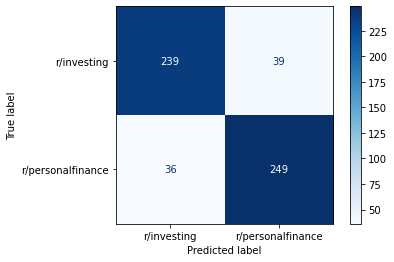

In [29]:
cvec = CountVectorizer()
bag = BaggingClassifier()

pipe_cvec_bag = Pipeline([
    ('cvec', cvec),
    ('bag', bag)
])

pipe_cvec_bag_params = {
    'cvec__max_features': [3000],
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,2)],
    'bag__max_samples': [1.0],
    'bag__max_features': [0.35],
    'bag__random_state': [42],
    'bag__n_jobs': [-1],
    'bag__bootstrap': [True]
}

gs_cvec_bag = GridSearchCV(
    estimator=pipe_cvec_bag,
    param_grid=pipe_cvec_bag_params,
    cv=5,
    verbose=1
)

model(gs_cvec_bag)

### TF-IDF Vectorizer Bagging Model

We used Pipeline and GridSearchCV to perform a TVEC Bagging Model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the Accuracy and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|TVEC Max Features|1000, 2000, 3000<br>4000, 5000</br>|3000|
|TVEC Ngram Range|(1, 1), (1, 2), (1, 3)<br>(1, 4), (1, 5), (1, 6)</br>|(1, 4)|
|Bagging Max Samples|0.25, 0.5, 0.75, 1.0|1.0|
|Bagging Max Features|0.10, 0.15, 0.20, 0.25<br>0.30, 0.35, 0.40</br>|0.30|

|Metric|Value|
|------|-----|
|Best Accuracy|86.4%|
|Train Accuracy|99.5%|
|Test Accuracy|87.2%|
|Misclassification|12.8%|
|Sensitivity|87.0%|
|Specificity|87.4%|
|Precision|87.6%|

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score:                                86.4%
Train Score:                               99.5%
Accuracy (Test Score):                     87.2%
Misclassification:                         12.8%
Sensitivity / True Positive Rate / Recall: 87.0%
Specificity / True Negative Rate:          87.4%
Precision / Positive Predictive Value:     87.6%
Best Parameters:                           {'bag__bootstrap': True, 'bag__max_features': 0.3, 'bag__max_samples': 1.0, 'bag__n_jobs': -1, 'bag__random_state': 42, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 4), 'tvec__stop_words': 'english'}


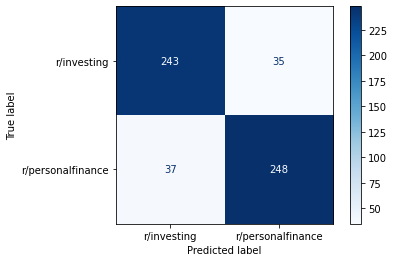

In [30]:
tvec = TfidfVectorizer()
bag = BaggingClassifier()

pipe_tvec_bag = Pipeline([
    ('tvec', tvec),
    ('bag', bag)
])

pipe_tvec_bag_params = {
    'tvec__max_features': [3000],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,4)],
    'bag__max_samples': [1.0],
    'bag__max_features': [0.3],
    'bag__random_state': [42],
    'bag__n_jobs': [-1],
    'bag__bootstrap': [True]
}

gs_tvec_bag = GridSearchCV(
    estimator=pipe_tvec_bag,
    param_grid=pipe_tvec_bag_params,
    cv=5,
    verbose=1
)

model(gs_tvec_bag)

### Comparing Bagging Results

We tabulate the best parameters found:

|Parameter|Best CVEC|Best TVEC|
|---------|---------|---------|
|Vectorizer Max Features|3000|3000|
|Vectorizer Ngram Range|(1, 2)|(1, 4)|
|Bagging Max Samples|1.0|1.0|
|Bagging Max Features|0.35|0.30|

**Observations:**

1. Inclusion of trigram and quadrigram in TVEC is more consequential as compared to CVEC, which uses only unigrams and bigrams.
2. Our bagging sample with replacement and a larger max sample provided the greatest predictive value than using less samples.
3. Penalization of terms using TVEC enables a greater weight to be applied to focus words in each subreddit. This explains why less max features used in TVEC as compared to a CVEC. 

Tabulating our results gives us:

|Model|Vectorizer|Best Accuracy|Train Accuracy|Test Accuracy|Sensitivity|Specificity|Precision|
|-----|----------|----------|-----------|---------------------|-----------|-----------|---------|
|Bagging|CVEC|86.4%|<font color='blue'>99.6%</font>|86.7%|<font color='blue'>87.4%</font>|86.0%|86.5%|
|Bagging|TVEC|86.4%|99.5%|<font color='blue'>87.2%</font>|87.0%|<font color='blue'>87.4%</font>|<font color='blue'>87.6%</font>|

**Note: We colorized the better value <font color='blue'>blue</font> for easier readability.**

**Observations:**

1. Overall, we find that a bagging model gives us a great results on our 4 main metrics: Accuracy, Sensitivity, Specificity and Precision.
2. Based on our results, a TF-IDF vectorizer scored better on 3 out of 4 of our metrics.
3. While CVEC train accuracy is better than TVEC train accuracy, CVEC accuracy is lower than TVEC accuracy. This suggests that there is a signifcant amount of noise present in our CVEC model using the same number of maximum features that is reduced in our TVEC model.
4. The effect of penalizing common words using TF-IDF seems to have provided a better predictive value than simply using a CVEC Vectorizer.
5. Based on our findings, a TF-IDF vectorized bagging model performs better than a Count Vectorized Bagging model.

**Conclusion: Better Vectorizer: TVEC**


## Random Forest Model

### CountVectorizer Random Forest Model

We used Pipeline and GridSearchCV to perform a CVEC Random Forest Model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the Accuracy and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|CVEC Max Features|2000, 3000<br></br>4000, 5000|3000|
|CVEC Ngram Range|(1, 1), (1, 2), (1, 3)<br></br>(1, 4), (1, 5)|(1, 4)|
|Random Forest Max Depth|20, 30, 40, 50, 60, 70|60|
|Random Forest n Estimators|100, 200, 300, 400<br></br>500, 600, 700<br></br>800, 900, 1000|600|
|Random Forest Max Features|0.007, 0.008, 0.009<br>0.01, 0.02, 0.03</br><br>0.04, 0.05, 0.075</br><br>0.10, 0.15, 0.20</br>|0.008|
|Random Forest Max Samples|0.60, 0.70, 0.75, 1.0|0.75|

|Metric|Value|-|
|------|-----|-|
|Best Accuracy|89.7%
|Train Accuracy|99.8%|
|Test Accuracy|90.9%|
|Misclassification|9.1%|
|Sensitivity|95.1%|
|Specificity|86.7%|
|Precision|88.0%|

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score:                                89.7%
Train Score:                               99.8%
Accuracy (Test Score):                     90.9%
Misclassification:                         9.1%
Sensitivity / True Positive Rate / Recall: 95.1%
Specificity / True Negative Rate:          86.7%
Precision / Positive Predictive Value:     88.0%
Best Parameters:                           {'cvec__max_features': 3000, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': 'english', 'rf__max_depth': 60, 'rf__max_features': 0.008, 'rf__max_samples': 0.75, 'rf__n_estimators': 600, 'rf__n_jobs': -1, 'rf__random_state': 42}


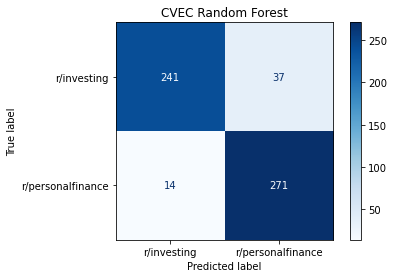

In [31]:
cvec = CountVectorizer()
rf = RandomForestClassifier()

pipe_cvec_rf = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

pipe_cvec_rf_params = {
    'cvec__max_features': [3000],
    'cvec__ngram_range': [(1, 4)],
    'rf__max_depth': [60],
    'rf__n_estimators': [600],
    'rf__max_features': [0.008],
    'rf__max_samples': [0.75],
    'cvec__stop_words': ['english'],
    'rf__random_state': [42],
    'rf__n_jobs': [-1],
}


gs_cvec_rf = GridSearchCV(
    estimator=pipe_cvec_rf, 
    param_grid=pipe_cvec_rf_params, 
    cv=5,
    verbose=1
)

model(gs_cvec_rf)
plt.title('CVEC Random Forest');

### TF-IDF Random Forest Model

We used Pipeline and GridSearchCV to perform a TVEC Random Forest Model based on a range of parameters. Below, we list the range of parameters for respective features and the best parameter used, as well as the Conclusion and other metrics results:

**Note: For ease of use and to reduce processing time, we have set the parameters in our code as the Best Parameters found.**

|Parameter|Range Used|Best|
|---------|-----|----|
|CVEC Max Features|2000, 3000<br></br>4000, 5000|3000|
|CVEC Ngram Range|(1, 1), (1, 2)<br></br>(1, 3), (1, 4)|(1, 3)|
|Random Forest Max Depth|10, 15, 20<br></br>25, 30|20|
|Random Forest n Estimators|100, 300, 400<br></br>500, 600, 700|600|
|Random Forest Max Features|0.004, 0.005, 0.006<br></br>0.007, 0.008, 0.009<br></br>0.01, 0.02|0.006|
|Random Forest Max Samples|0.5, 0.75, 1.0|0.75|

|Metric|Value|
|------|-----|
|Best Conclusion|89.5%|
|Train Conclusion|98.5%|
|Test Accuracy|90.8%|
|Misclassification|9.2%|
|Sensitivity|95.1%|
|Specificity|86.3%|
|Precision|87.7%|

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score:                                89.5%
Train Score:                               98.5%
Accuracy (Test Score):                     90.8%
Misclassification:                         9.2%
Sensitivity / True Positive Rate / Recall: 95.1%
Specificity / True Negative Rate:          86.3%
Precision / Positive Predictive Value:     87.7%
Best Parameters:                           {'rf__max_depth': 20, 'rf__max_features': 0.006, 'rf__max_samples': 0.75, 'rf__n_estimators': 600, 'rf__n_jobs': -1, 'rf__random_state': 42, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}


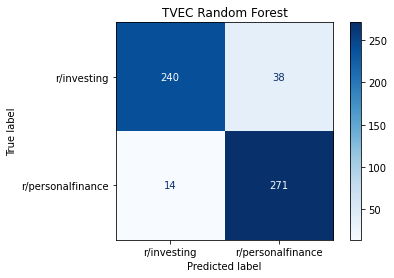

In [32]:
tvec = TfidfVectorizer()
rf = RandomForestClassifier()

pipe_tvec_rf = Pipeline([
    ('tvec', tvec),
    ('rf', rf)
])

pipe_tvec_rf_params = {
    'tvec__ngram_range': [(1, 3)],
    'tvec__max_features': [3000],
    'rf__max_depth': [20],
    'rf__n_estimators': [600],
    'rf__max_features': [0.006],
    'rf__max_samples': [0.75],
    'tvec__stop_words': ['english'],
    'rf__random_state': [42],
    'rf__n_jobs': [-1],

}

gs_tvec_rf = GridSearchCV(
    estimator=pipe_tvec_rf, 
    param_grid=pipe_tvec_rf_params, 
    cv=5,
    verbose=1
)

model(gs_tvec_rf)
plt.title('TVEC Random Forest');

### Comparing Random Forest Results

We tabulate the best parameters found:

|Parameter|Best CVEC|Best TVEC|
|---------|---------|---------|
|Vectorizer Max Features|3000|3000|
|Vectorizer Ngram Range|(1, 4)|(1, 3)|
|Random Forest Max Depth|60|20|
|Random Forest n Estimators|600|600|
|Random Forest Max Features|0.008|0.006|
|Random Forest Max Samples|0.75|0.75|

**Observations:**

1. While both vectorizers use the same number of max features, a TF-IDF vectorized model used less features in creating a random forest model. This may be due to the effect of TF-IDF vectorized model penalizing common words and assign a larger weightage on the word tokens.
2. Our CVEC model used a higher range of ngrams, including a quadrigram, which is absent from our TVEC model. This suggests that the usage of a quadrigram provided no additional predictive power when applied to our TVEC model, whereas the opposite is true for our CVEC model.
3. For both models, while we had provided a larger range for the random forest n estimators, the model selected a lower value. This suggests that using more estimators beyond what the model selected does not bring more predictive power to our model, and may instead reduce it.

Tabulating our results gives us:


|Model|Vectorizer|Best Accuracy|Train Accuracy|Test Accuracy|Sensitivity|Specificity|Precision|
|-----|----------|----------|-----------|---------------------|-----------|-----------|---------|
|Random Forest|CVEC|<font color='blue'>89.7%</font>|<font color='blue'>99.8%</font>|<font color='blue'>90.9%</font>|95.1%|<font color='blue'>86.7%</font>|<font color='blue'>88.0%</font>|
|Random Forest|TVEC|89.5%|98.5%|90.8%|95.1%|86.3%|87.7%

**Note: We colorized the better value <font color='blue'>blue</font> for easier readability.**

**Observations:**

1. Based on our results, a Count vectorizer had scored better on 3 out of 4 of our metrics (accuracy, sensitivity, specificity, precision).
2. CVEC train and test are better than TVEC train and test accuracy.
3. We observe that while both train accuracy is nearly 100%, the test score is 8-9 percentage points lower. The drastic drop in training and testing accuracy suggests that our optimized random forest models may be overfitted to our training accuracy.
4. Noting the above, we recommend using other models which may have less cause of concern from overfitting.

**Conclusion: Better Vectorizer: CVEC slightly better**


## Final Model Selection

We tabulate our entire model findings onto the table below:


|Model|Vectorizer|Best Accuracy|Train Accuracy|Test Accuracy<br></br>|Sensitivity|Specificity|Precision|Weighted<br>Average</br>|Remarks|Chosen Model|
|-----|----------|----------|-----------|--------------------|-----------|-----------|----------|-----------------|-------|---------------|
|Logistic Regression|CVEC|89.0%|96.4%|89.7%|92.3%|87.1%|88.0%|89.28%|TVEC Preferred to CVEC||
|Logistic Regression|TVEC|90.0%|91.9%|90.8%|91.6%|<font color='blue'>89.9%</font>|<font color='blue'>90.3%</font>|90.65%|Highest Predictive Value<br>Highest Specificity Rate</br>|Yes|
|Naive Bayes|CVEC|88.9%|91.8%|90.6%|<font color='blue'>97.9%</font>|83.1%|85.6%|89.30%|TVEC Preferred to CVEC||
|Naive Bayes|TVEC|<font color='blue'>90.5%</font>|94.0%|<font color='blue'>91.7%</font>|95.8%|87.4%|88.6%|<font color='blue'>90.88%</font>|2nd Highest Predictive Value<br>2nd Highest Specificity Rate</br>|Yes|
|Decision Tree|CVEC|80.7%|<font color='blue'>100%</font>|81.3%|85.6%|77.0%|79.2%|80.78%|TVEC Preferred to CVEC||
|Decision Tree|TVEC|79.3%|97.5%|78.7%|80.7%|76.6%|78.0%|78.50%|Overfit to train data<br></br>Low Specificity and Precision||
|Bagging|CVEC|86.4%|99.6%|86.7%|87.4%|86.0%|86.5%|86.65%|TVEC Preferred to CVEC||
|Bagging|TVEC|86.4%|99.5%|87.2%|87.0%|87.4%|87.6%|87.30%|Overfit to train data||
|Random Forest|CVEC|89.7%|99.8%|90.9%|95.1%|86.7%|88.0%|90.18%|TVEC Preferred to CVEC||
|Random Forest|TVEC|89.5%|98.5%|90.8%|95.1%|86.3%|87.7%|89.98%|Overfit to train data||

**Note: We colorized the best value <font color='blue'>blue</font> for easier readability.**


**1. Eliminate CVEC Models**

Based on our findings in the earlier comparisons between CVEC and TVEC models, we believe that a TVEC model is more appropriate to use because the penalization of common words in through TF-IDF provides a greater weight on the focus words within the dataset. The focus words in turn provide greater predictive power than compared to simply counting word frequency as per CVEC. This leaves us with CVEC models.

**2. Eliminate Decision Tree, Bagging and Random Forest Models**

We eliminate the decision tree bagging and random forest models due to overfitting to training data. Whereas their train accuracy is very high (97%+), they do much worse on their testing data, with a high percentage difference between the two. This concerns us because if a testing data were to perform significantly worse than our training data, this will translate to an significantly worse result when tested against a blind data. Furthermore, these models perform less well in our area of concern: Specificity.

**Conclusions**

We select the TVEC logistic regression and TVEC naive bayes models as our predictive models to present to our clients due to the following factors:

1. Low overfitting to training data. Therefore, these models should perform better for blind data, such as when collecting new posts.
2. Highest specificity. Our clients' main limitation is in their small marketing budget. As such, we select the models with the highest rates of specificity to ensure that we are not incorrectly spending funds.
3. Additionally, the lack of investment advisor license by Coach Ella means that we should avoid spending advertising funds for potential clients seeking investment advice.

# Explanatory Data Analysis <a class="anchor" id="EDA"></a>

In this section, we explain the characteristics of our findings.

We conduct a feature importance analysis and misclassification analysis on one of our best models, the TF-IDF cectorized logistic regression model. First, we recreate the codes for TVEC logistic modeling locally on the cells below. The codes are almost identical to those found in Part 4.4.2. (logistic regression model) and the overall function from 4.3.

In [33]:
# X and y are both Series
X = clean_df['tok_snow_all_text']
y = clean_df['subreddit_personalfinance']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=42,
                                                  stratify=y)

tvec = TfidfVectorizer()
logit = LogisticRegressionCV()

pipe_tvec_logit = Pipeline([
    ('tvec', tvec),
    ('logit', logit)])

pipe_tvec_logit_params = {
    'tvec__max_features': [3000],
    'tvec__ngram_range': [(1,4)],
    'logit__n_jobs': [-1],
    'logit__random_state': [42],
    'logit__cv': [15]
}

gs_tvec_logit = GridSearchCV(
    estimator=pipe_tvec_logit,
    param_grid=pipe_tvec_logit_params,
    cv=5)

gs_tvec_logit.fit(X_train, y_train)
y_preds_tvec_logit = gs_tvec_logit.predict(X_test)

## Feature Importance

### Top Key Words

We find the top 10 key words by strength of both positive and negative values from our TVEC Logistic Regression model and tabulate the results:

**Note: Some words have been corrected to be more human readable**

|Key Word|Multiplier|   |   |Key Word|Multiplier|
|--------|----------|||--------|----------|
|Loan       |5.86|||Growth     |0.43
|Car        |5.43|||Million    |0.41
|Credit     |5.38|||Crypto     |0.40
|Pay        |4.31|||ETF        |0.39
|Card       |4.05|||Price      |0.37
|Job        |4.02|||Trade      |0.32
|Save       |3.79|||Company    |0.29
|Tax        |3.45|||Share      |0.25
|Payment    |3.36|||Market     |0.21
|Insurance  |3.29|||Stock      |0.11

In [34]:
snow_stem.stem('loaning')

'loan'

We read the results as such: inclusion of such word or its permutations translate to (multiplier) times as likely that the post originates from the subreddit r/personalfinance.

**Illustrations:**

- Loan: If a title or text contains the word 'loan', 'loans', 'loaning', the post is 5.86 times as likely to be from the subreddit r/personalfinance. If two of the word 'loan', 'loans' or 'loaning' is present, it is 5.86$^2$ more likely to originate from the subreddit r/personalfinance.
- Stock: If a title or a text contains the word 'stock', 'stocks', or other permutations, the post is 0.11 times as likely to originate from the subreddit r/personalfinance.
- Loan and Stock: If a title or text contains one iteration of 'loan' and 'stock', the post is 0.64 (5.86 x 0.11) times as likely to originate from the subreddit r/personalfinance.

In [35]:
# Combine both into a dataframe. 
# Without [0], an error will appear due to different size (1, 3000) vs (3000, 3000). 
# By using [0], we are reducing both to a (1, 3000) shape.
feat_impt = pd.DataFrame(
    gs_tvec_logit.best_estimator_['logit'].coef_[0], 
    index=gs_tvec_logit.best_estimator_['tvec'].get_feature_names())

np.exp(feat_impt[0].sort_values(ascending=False).head(10))

loan       5.861770
car        5.429199
credit     5.375380
pay        4.312655
card       4.050811
job        4.020727
save       3.792266
tax        3.452388
payment    3.358997
insur      3.292223
Name: 0, dtype: float64

In [36]:
np.exp(feat_impt[0].sort_values(ascending=False).tail(10))

growth     0.426153
million    0.409213
crypto     0.396061
etf        0.393904
price      0.365431
trade      0.320765
compani    0.293874
share      0.245357
market     0.214663
stock      0.112044
Name: 0, dtype: float64

### Distribution of Key Words Strength

The graph belos shows the distribution of the key words strength used in our TVEC Logistic Regression.

**Observations and Explanations:**

1. We see a unimodal distribution with a very prominent peak at the 0.0 bin. 
2. This suggests that while our model had chosen 3000 features to use, there is a high number of features which have very little predictive power, hence the peak at the 0.0 bin.
3. There is a larger area to the left of the peak as compared to the right.
4. This suggests that there are more key words with greater strength which are used to predict if post originates from the 'investing' subreddit.
5. The higher frequency of key words in the r/investing subreddit is owed to the more specific nature of the subreddit. Key words in this subreddit relate to the sector's lingos used to describe and discuss the topic at hand, such as 'stock', 'market', 'share', 'valuation', 'debt', 'PE' (price to earnings, a metric used in finance). 
6. Meanwhile, personal finance is a broader subject. As such, while there are some key words used such as 'personal' (loan), 'student' loan, 'credit', 'card', 'nest', etc, there are still a broader range of words used to describe one's personal financial state.

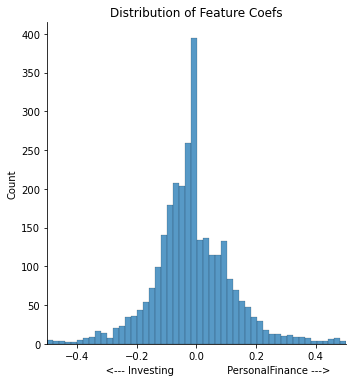

In [37]:
sns.displot(feat_impt, legend=False)
plt.xlim(-0.5, 0.5)
plt.title('Distribution of Feature Coefs')
plt.xlabel('              <--- Investing                 PersonalFinance --->');

## Misclassification Analysis


Misclassification is often produced due to the lack of contextual knowledge. Since the algorithms applied has no knowledge on natural human language patterns, it takes numerical weights of word distributions to predict the results instead. Such are the limitations of the modeling we have applied onto our datasets.

We create a dataframe of the test set and its corresponding predicted values. The dataframe was made by merging 3 series/numpy arrays: X_test, y_test and predicted y (y_preds).

In [38]:
misclass_df = pd.DataFrame(y_preds_tvec_logit, X_test)
misclass_df.reset_index(inplace=True)

misclass_df.rename(columns={0: 'predictions'}, inplace=True)
misclass_df = pd.concat(
    objs=[misclass_df, y_test.reset_index(drop=True)], axis=1).rename(
    columns={'subreddit_personalfinance': 'true'})

Next, we create a list to classify whether a text was a false positive (predicted to be 1 but is actually 0) or a false negative (predicted to be 0 but is actually 1).

In [39]:
# Create empty list to store false positive and false negative text
false_positive_list = []
false_negative_list = []
true_positive_list = []
true_negative_list = []

for index_number in misclass_df.index:
    if misclass_df['predictions'][index_number] > misclass_df['true'][index_number]:
        false_positive_list.append(misclass_df['tok_snow_all_text'][index_number])
    elif misclass_df['predictions'][index_number] < misclass_df['true'][index_number]:
        false_negative_list.append(misclass_df['tok_snow_all_text'][index_number])
    elif (misclass_df['predictions'][index_number] == 1) & (misclass_df['true'][index_number] == 1):
        true_positive_list.append(misclass_df['tok_snow_all_text'][index_number])
    else:
        true_negative_list.append(misclass_df['tok_snow_all_text'][index_number])

### Analysis of False Positive Text

We analyze the text on some false positives.

**Explanation**

False positives are datapoints which we had predicted to originate from r/personalfinance but is actually from r/investing.
We quote some text below and explain why they may have been misclassified:


**Text 1:**

>'anyon heard alitass take someon japan recommend check sign throw away email account would like know anyon heard custom support team charg say onli advertis asia lead believ could possibl real thing case whi use email account need know anyon know legitim thank everyon assist'

The above text may have been misclassified due to the great usage of broader words which are less prevalent in our r/investing texts. Contextually, it appears that the text had nothing to do with personal finance nor investing. However, due to the weightage of each word in our model, the model decided that it is more likely to be from r/personalfinance. As such, the data results in a false positive.

**Text 2:**

>'question peopl smarter let lay basic semi educ financ anyth profession simpli someth enjoy research know basic year old goal max roth ira everi year k <font color='blue'>vanguard</font> roth ira normal brokerag vanguard k also chunk k sit td ameritrad anyth hope individu stock okay risk want becom knowledg find strong stock buy debt next year business <font color='blue'>school</font> paid k left <font color='blue'>save</font> month left work k save next year live parent next two month cheap rent gas small cost worri howev work pretti much <font color='blue'>full time job</font> ton time abl research besid really onli know basic taught td ameritrad educ center mess around papermoney think swim actual found coupl stock done well cours actual money question ditch tda move chunk money index <font color='blue'>vanguard</font> probabl small cap value reit someon good growth keep tri learn take risk individu stock spend time let know think'

**Note: Words more associated to true result is colored <font color='blue'>blue</font>.**

This text uses both focus words from r/investing and r/personalfinance. However, due to the higher weight of focus words from r/personalfinance such as 'full time job', 'vanguard', 'school', this observation is predicted to be from r/personalfinance. The lack of contextual understanding in NLP models cause misclassifications due to our model's sole reliance onto numerical analysis.

In [40]:
false_positive_list[0]

'anyon heard alitass take someon japan recommend check sign throw away email account would like know anyon heard custom support team charg say onli advertis asia lead believ could possibl real thing case whi use email account need know anyon know legitim thank everyon assist'

In [41]:
false_positive_list[7]

'question peopl smarter let lay basic semi educ financ anyth profession simpli someth enjoy research know basic year old goal max roth ira everi year k vanguard roth ira normal brokerag vanguard k also chunk k sit td ameritrad anyth hope individu stock okay risk want becom knowledg find strong stock buy debt next year busi school paid k left save month left work k save next year live parent next two month cheap rent gas small cost worri howev work pretti much full time job ton time abl research besid realli onli know basic taught td ameritrad educ center mess around papermoney think swim actual found coupl stock done well cours actual money question ditch tda move chunk money index vanguard probabl small cap valu reit someon good growth keep tri learn take risk individu stock spend time let know think'

We create a function to turn the lists into a set. We are using a set because we are more interested in the nature of the words misclassified and less on its frequency.

### Analysis of False Negative Text

False negatives are datapoints which we had predicted to originate from r/investing but is actually from r/personalfinance.
We quote some text below and explain why they may have been misclassified:

**Text 1:**
> 'short vs <font color='blue'>long term</font> gain multipl share singl <font color='blue'>etf</font> question question long vs short term hold determin anyon resourc could steer toward <font color='blue'>etf</font> buy one <font color='blue'>share</font> per month around began juli time next year <font color='blue'>share</font> time would onli elig sell one <font color='blue'>share</font> bought one year prior classifi long term gain assum appreci gain calcul singular <font color='blue'>share</font> determin want sell next juli would th total gain classifi long term gain ths short term'

**Note: Words more associated to true result is colored <font color='blue'>blue</font>.**

By context, this datapoint seems to originate from r/investing due to the key words used such as 'ETF', 'share', and 'long term'. Some misclassification such as these arise due to authors posting on an incorrect/unrelated/semi-related subreddit. Misclassification such as these are uncontrollable and thus we cannot do anything to resolve this.

**Text 2:**
>'create budget template thought could share link make copies document sheet edit want something could punch number would calculate automatically guess someone else need might well share harm yes'

This datapoint is likely to be misclassified due to its short length. As such, our model had limited features to use to decide which subreddit the text originated from. Perhaps this can be improved by adding data on word count in the text.

In [42]:
false_negative_list[-1]

'short vs long term gain multipl share singl etf question question long vs short term hold determin anyon resourc could steer toward etf buy one share per month around began juli time next year share time would onli elig sell one share bought one year prior classifi long term gain assum appreci gain calcul singular share determin want sell next juli would th total gain classifi long term gain ths short term'

In [43]:
false_negative_list[-20]

'creat budget templat thought could share link make copi document sheet edit want someth could punch number would calcul automat guess someon els need might well share harm yes'

### Similarity of Words Used

The following are a list of words found to be used in predictions.

In [44]:
def list_to_set(list_name):
    new_set = set()
    for string_text in list_name:
        split_list = string_text.split(sep=' ')
        for word in split_list:
            new_set.add(word)
    return new_set

We group our findings to have a better view of the words found to be misclassified or classified correctly.

We tabulate the number of words found in each instance of true/false positive/negative below:

|Result|Count|
|------|-----|
|True  Positive  |  2614|
|True  Negative  |  4545|
|False Positive  |  699|
|False Negative  |  690|

We tabulate the number of words used in both false and true cases, as well as the number of words used in all cases:

|Grouping|Count|
|--------|-----|
|True  Intersect |  1736|
|False Intersect |  302|
|All   Intersect |  286|

In [45]:
true_positive_set = list_to_set(true_positive_list)
true_negative_set = list_to_set(true_negative_list)
false_positive_set = list_to_set(false_positive_list)
false_negative_set = list_to_set(false_negative_list)
print(f'True  Positive  Count:  {len(true_positive_set)}')
print(f'True  Negative  Count:  {len(true_negative_set)}')
print(f'False Positive  Count:  {len(false_positive_set)}')
print(f'False Negative  Count:  {len(false_negative_set)}')
true_intersect = true_positive_set.intersection(true_negative_set)
false_intersect = false_positive_set.intersection(false_negative_set)
all_intersect = true_intersect.intersection(false_intersect)
print(f'True  Intersect Count:  {len(true_intersect)}')
print(f'False Intersect Count:  {len(false_intersect)}')
print(f'All   Intersect Count:  {len(all_intersect)}')

True  Positive  Count:  2614
True  Negative  Count:  4545
False Positive  Count:  699
False Negative  Count:  690
True  Intersect Count:  1736
False Intersect Count:  302
All   Intersect Count:  286


**Some other findings:**

1. Datapoints with the words 'broad', 'cap', 'idk', 'married', 'spouse', and 'disabled' are **always** incorrectly classified. Dropping these words may positively impact our models or result in an overfitting.
2. Datapoints with the words 'healthcare', 'technnology', 'skyrocket', 'die' and 'sick' are **always** correctly classified.

3. We find that some words appear on all True and False Positive and Negative. A snippet of the words found:

> 'Portfolio', 'Portion', 'Price', 'Question', 'Rather', 'Money', 'Miss', 'Learn'

The words selected above are focus words. However, contextually, this may be used in both subreddits. As such, these words may have negligible effect on our prediction model. However, the opposite may also be true. Such words may play a role, albeit a small one, and should remain included in our token words.

# Conclusion and Recommendations <a class="anchor" id="CR"></a>

## Conclusion

Our final model provides us the following results:

|Model|Vectorizer|Best Accuracy|Train Accuracy|Test Accuracy<br></br>|Sensitivity|Specificity|Precision|Weighted<br>Average</br>|
|-----|----------|----------|-----------|--------------------|-----------|-----------|----------|-----------------|
|Logistic Regression|TVEC|90.0%|91.9%|90.8%|91.6%|89.9%|90.3%|90.65%|

We conclude by stating our findings, and providing a recommendation based on our client's request.

In comparing our lemmatizer, porter stem and snow stem, we find that snow stem performs best on stemming the words in our text. Comparing snow to lemmatizer, snow is more aggressive in its stemming, thus it is able to reduce plurals into singulars. Comparing snow to porter, snow does not reduce adverbs (words ending with -ly, e.g. lightly, explicitly) the way that porter does (into lightli and explicitli). However, in some cases, snow does a better job finding its root word instead. As such, we have selected a snow stemmer as our stemming method.

In comparing our parameters, we find that a higher parameter number does not automatically translate to a better result. This is due to the diminishing returns in predictive power of the parameters. We also find that using an ngram range is better than using singular words only. This is because focus words often come in a phrase, similar to why supermarkets place soft drinks next to pizzas, or why casket-sellers also sell flowers. In all three cases, things which complement one another are often used consecutively.

In comparing our models, we find that a TF-IDF vectorized model provides a better predictive value than a Count Vectorized model. This is because while some stop words have been removed, there are still many stop words prevalent in our dataset. TF-IDF balances out the frequency of words used by penalizing common words which are not explicitly found in our stop words. This provides a higher weightage for non-stop words. Among the non-stop words, some of these are focus words used in the different subreddits due to their different focus. 

In comparing our two best models, we prefer using our logistic regression model as compared to our naive bayes model. Two reasons for this: maximization of our focus metric, and best overall balance in our 4 metrics. Our focus metric, specificity, performed best in a logistic regression. Due to the client's request of minimizing their incorrect spending, we desire the highest specificity in our models. In addition, our logistic regression scores over 90% on 3 out of 4 metrics, while specificity scores a hair below 90%, at 89.9%. Our naive bayes performed an impressive 95%+ on sensitivity, but poorly for specificity and precision (87.4% and 88.6% respectively). As such, while an equally weighted result points to using a naive bayes model (90.88% vs 90.65%), we believe that a logistic regression would be more reliable overall to meet the request of Coach Ella Advisory.



## Recommendation

We recommend using our logistic regression model for reasons provided above. To improve our model, we suggest a few things that we can do in the future:

1. Expand data collection from other sources (not just Reddit).
2. Identifying more stop words to reduce noise in our data.
3. Creating a dictionary to process words (stemming) more appropriately.
4. Obtain greater computing power or more time to process a greater number of hyperparameters.